In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from ydata_profiling import ProfileReport
import arff as ar

%matplotlib inline

In [130]:
with open('../data/phishing-dataset.arff', 'r') as f:
    lines = f.readlines()

data_lines = [line.strip() for line in lines if not line.startswith('@') and line.strip()]

data = [line.split(',') for line in data_lines]
col_names = [line.split()[1] for line in lines if line.startswith('@attribute')]
dataset = pd.DataFrame(data, columns=col_names)

dataset.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [131]:
dataset['Redirect'].value_counts()

Redirect
0    9776
1    1279
Name: count, dtype: int64

In [140]:
dataset = dataset.astype('category')

In [141]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   having_IP_Address            11055 non-null  category
 1   URL_Length                   11055 non-null  category
 2   Shortining_Service           11055 non-null  category
 3   having_At_Symbol             11055 non-null  category
 4   double_slash_redirecting     11055 non-null  category
 5   Prefix_Suffix                11055 non-null  category
 6   having_Sub_Domain            11055 non-null  category
 7   SSLfinal_State               11055 non-null  category
 8   Domain_registeration_length  11055 non-null  category
 9   Favicon                      11055 non-null  category
 10  port                         11055 non-null  category
 11  HTTPS_token                  11055 non-null  category
 12  Request_URL                  11055 non-null  category
 13  U

In [142]:
dataset['Result'].value_counts()

Result
1     6157
-1    4898
Name: count, dtype: int64

In [143]:
dataset.describe().style.format(precision=2)

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055
unique,2,3,2,2,2,2,3,3,2,2,2,2,2,3,3,3,2,2,2,2,2,2,2,2,2,3,2,2,3,2,2
top,1,-1,1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,1,1,1,1,1,1,1,-1,1,0,1,1
freq,7262,8960,9611,9400,9626,9590,4070,6331,7389,9002,9553,9259,6560,5337,4449,8440,9041,9426,9776,9740,10579,8918,10043,5866,7612,5831,8201,9516,6156,9505,6157


In [144]:
for feature in dataset.columns:
    print(f'Feature {dataset[feature].value_counts()}\n')

Feature having_IP_Address
1     7262
-1    3793
Name: count, dtype: int64

Feature URL_Length
-1    8960
1     1960
0      135
Name: count, dtype: int64

Feature Shortining_Service
1     9611
-1    1444
Name: count, dtype: int64

Feature having_At_Symbol
1     9400
-1    1655
Name: count, dtype: int64

Feature double_slash_redirecting
1     9626
-1    1429
Name: count, dtype: int64

Feature Prefix_Suffix
-1    9590
1     1465
Name: count, dtype: int64

Feature having_Sub_Domain
1     4070
0     3622
-1    3363
Name: count, dtype: int64

Feature SSLfinal_State
1     6331
-1    3557
0     1167
Name: count, dtype: int64

Feature Domain_registeration_length
-1    7389
1     3666
Name: count, dtype: int64

Feature Favicon
1     9002
-1    2053
Name: count, dtype: int64

Feature port
1     9553
-1    1502
Name: count, dtype: int64

Feature HTTPS_token
1     9259
-1    1796
Name: count, dtype: int64

Feature Request_URL
1     6560
-1    4495
Name: count, dtype: int64

Feature URL_of_Anchor
0 

In [88]:
profile = ProfileReport(dataset,
                        title='Phishing Websites Dataset'
                        )
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
profile.to_file('../outputs/profile_phishing_websites.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='Result', ylabel='count'>

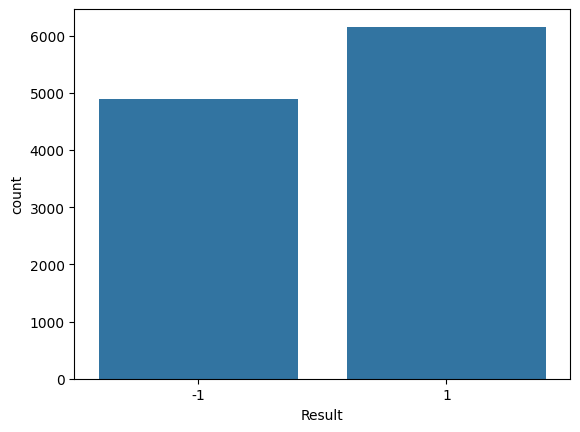

In [145]:
sns.countplot(x=dataset['Result'])

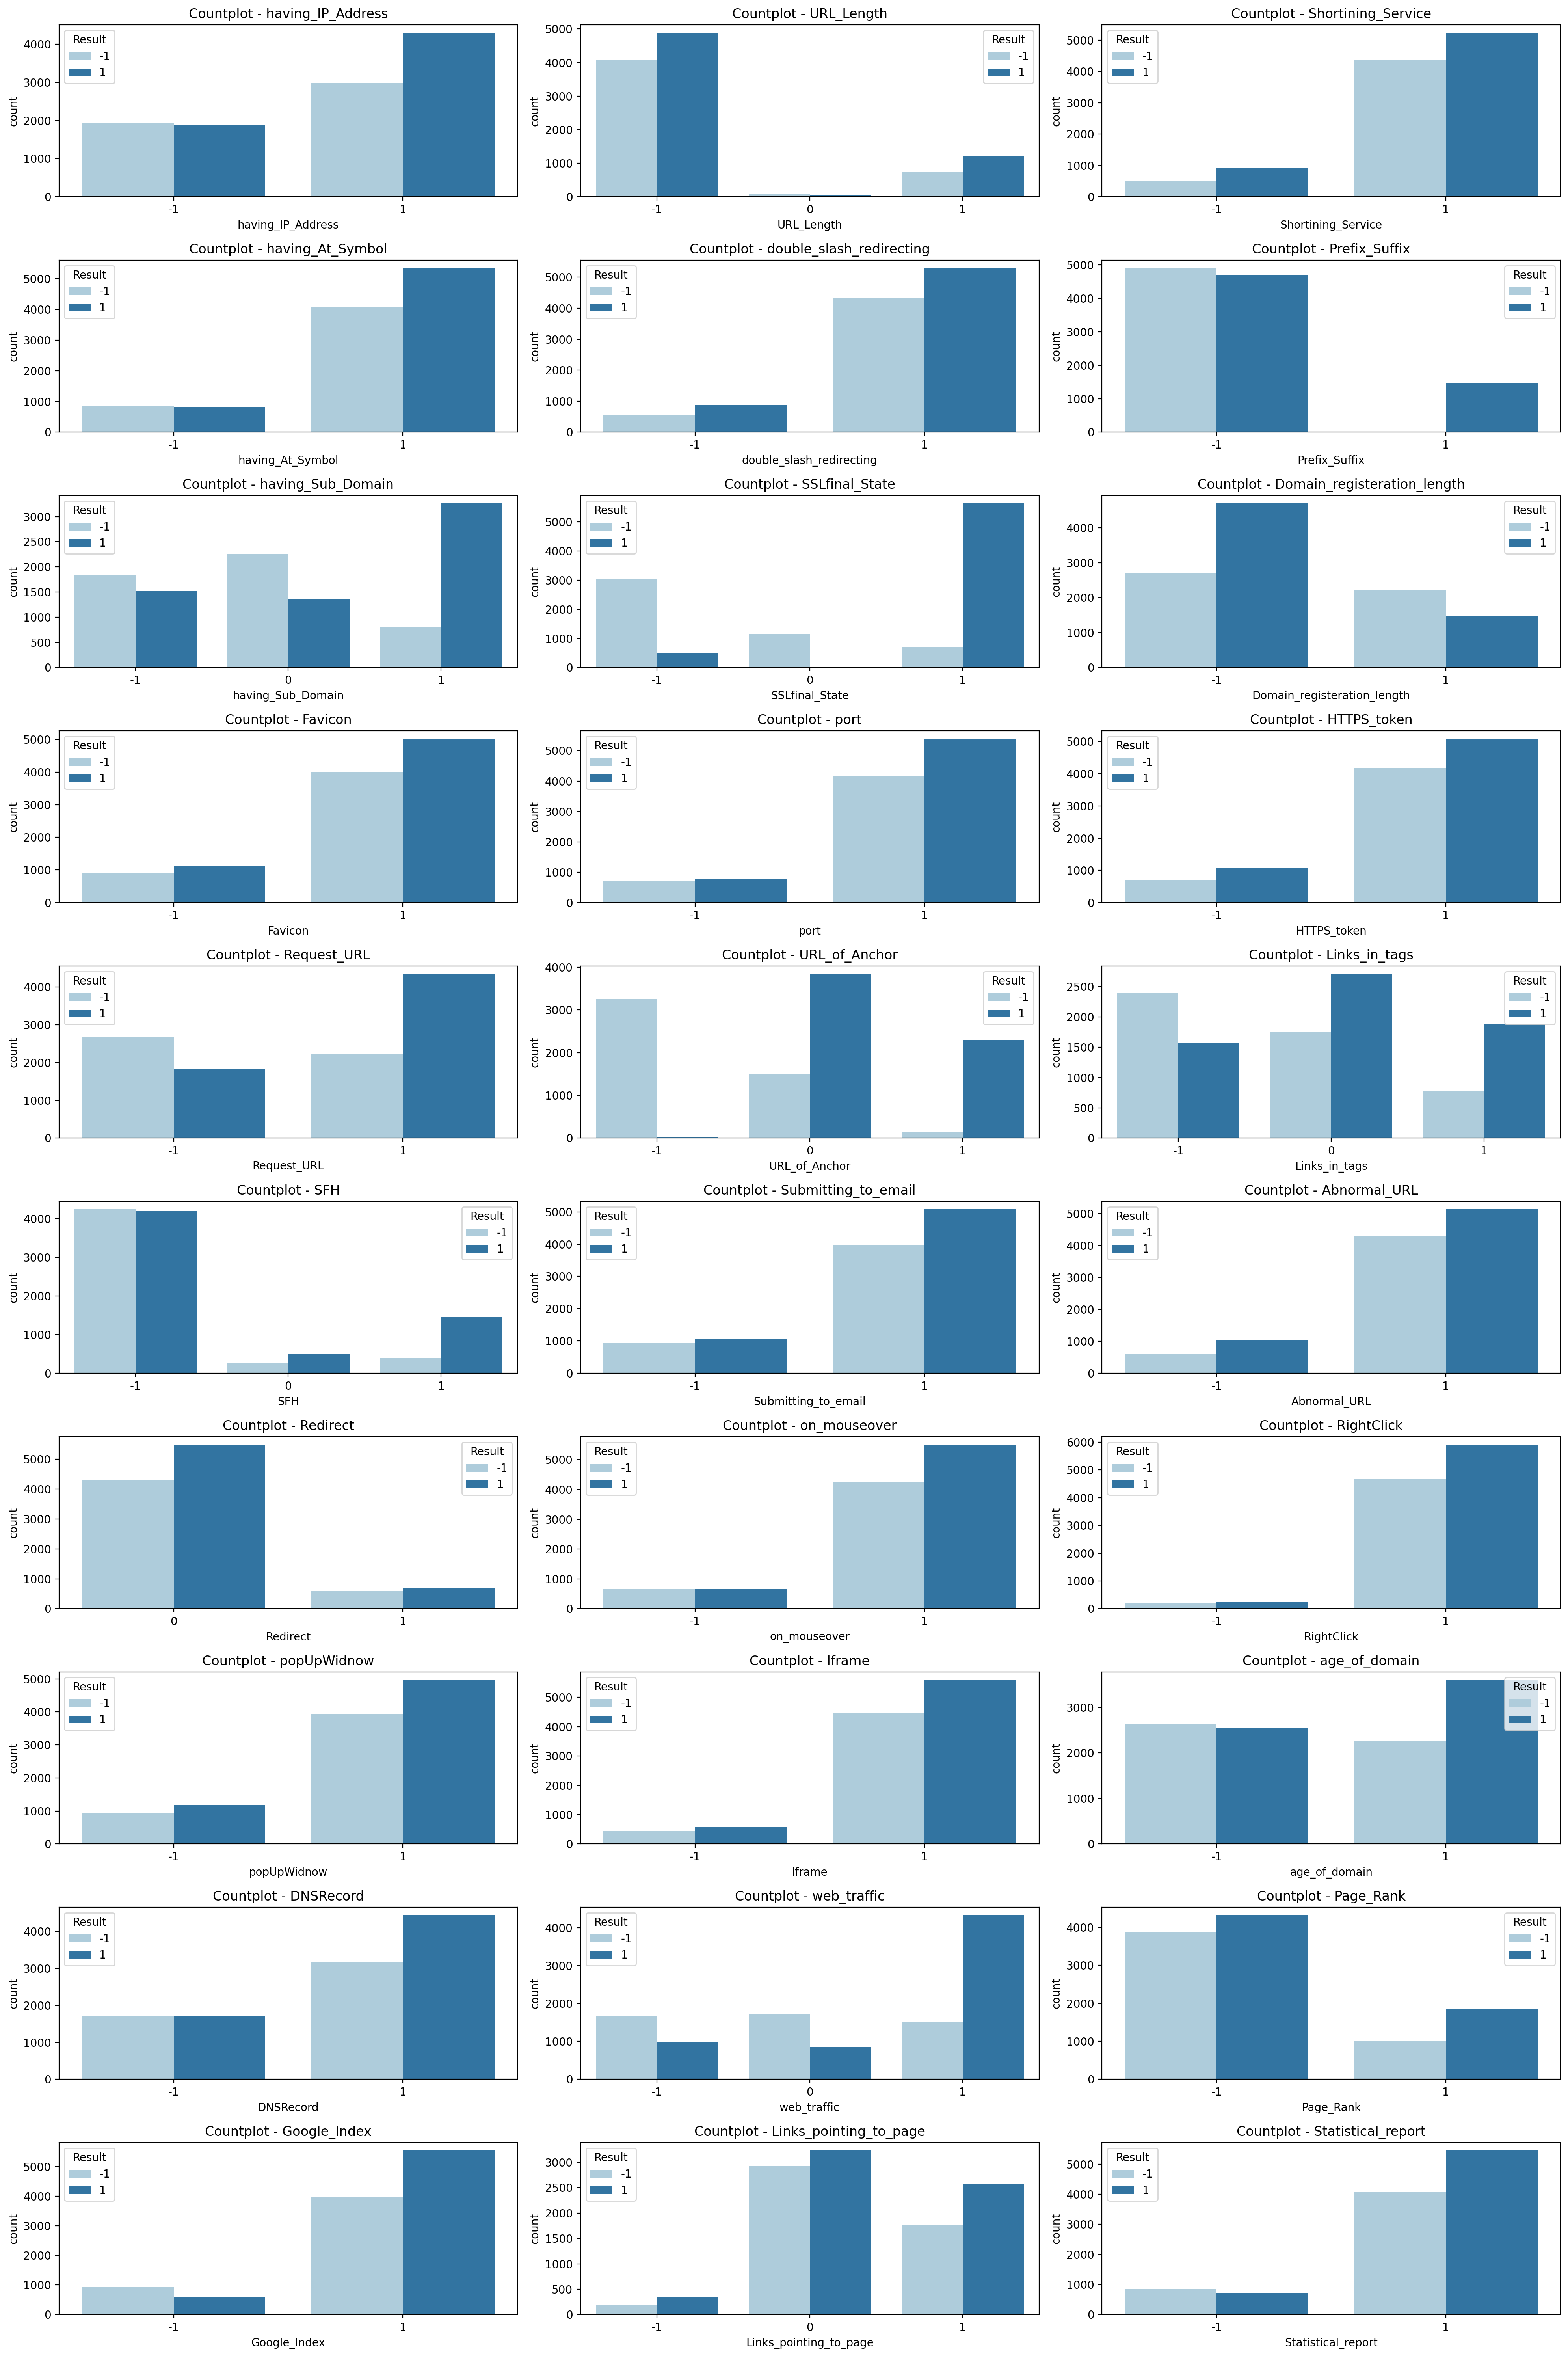

In [146]:
fig, axes = plt.subplots(10, 3, figsize=(20, 30), dpi=200)
for ax, feature in zip(axes.flat, dataset.columns):
    sns.countplot(data=dataset, x=feature, hue='Result', ax=ax, palette=sns.color_palette("Paired")[0:2])
    ax.set_title(f'Countplot - {feature}')
plt.tight_layout()
plt.show()

<Axes: >

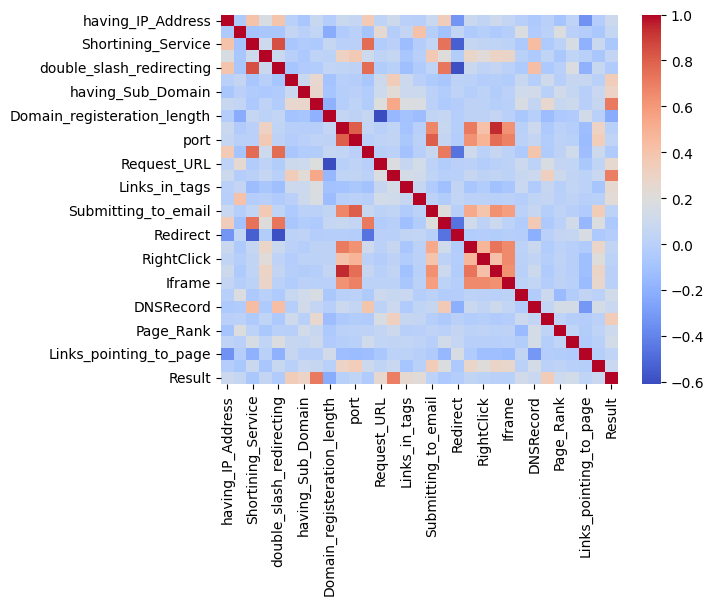

In [147]:
matrix = dataset.corr()
sns.heatmap(matrix, cmap="coolwarm", annot=False)

<Axes: >

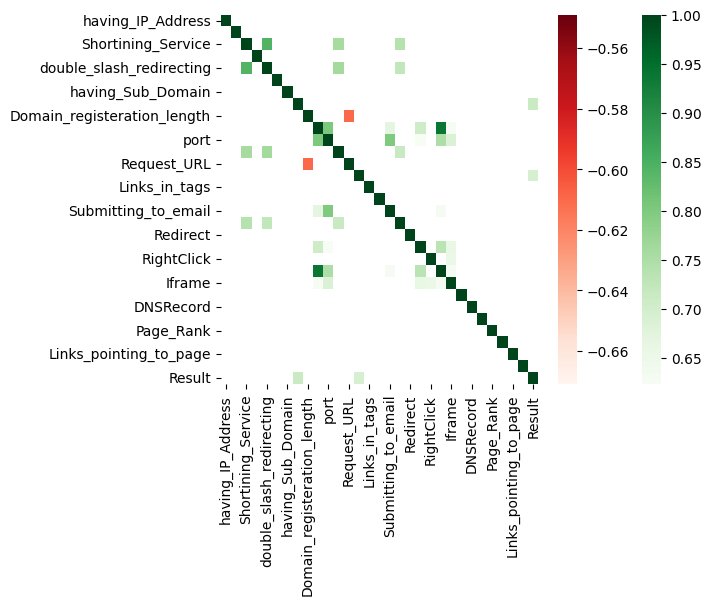

In [148]:
high_corr = matrix[matrix > 0.6]
low_corr = matrix[matrix < -0.6]

sns.heatmap(high_corr, cmap="Greens")
sns.heatmap(low_corr, cmap="Reds")

In [149]:
dataset['Result'].head()

0   -1
1   -1
2   -1
3   -1
4    1
Name: Result, dtype: category
Categories (2, int32): [-1, 1]

In [123]:
from sklearn.ensemble import RandomForestClassifier

def tree_based_feature_selection(df, target):
    model = RandomForestClassifier()
    model.fit(df.drop(target, axis=1), df[target])
    
    feature_importances = pd.Series(model.feature_importances_, index=df.drop(target, axis=1).columns)
    selected_features = feature_importances[feature_importances > 0.01].index
    return selected_features

selected_features = tree_based_feature_selection(dataset, target='Result')
print(f"Selected features: {selected_features}")

Selected features: Index(['having_IP_Address', 'Prefix_Suffix', 'having_Sub_Domain',
       'SSLfinal_State', 'Domain_registeration_length', 'Request_URL',
       'URL_of_Anchor', 'Links_in_tags', 'SFH', 'age_of_domain', 'DNSRecord',
       'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page'],
      dtype='object')


In [155]:
dataset['Result'] = dataset['Result'].astype(int)
dataset['Result']

0       -1
1       -1
2       -1
3       -1
4        1
        ..
11050    1
11051   -1
11052   -1
11053   -1
11054   -1
Name: Result, Length: 11055, dtype: int32

In [156]:
dataset['Result'].value_counts()

Result
 1    6157
-1    4898
Name: count, dtype: int64

In [157]:
dataset.loc[dataset['Result'] == -1, 'Result'] = 0

In [ ]:
X = dataset.drop(columns='Result')
y = dataset['Result']

In [161]:
from sklearn.neural_network import MLPClassifier


classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, random_state=0)
classifier.fit(X,y)

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=500, random_state=0)

In [162]:
import dalex as dx

exp = dx.Explainer(classifier, X, y)

mp = exp.model_parts(loss_function = 'rmse')

mp.plot()

Preparation of a new explainer is initiated

  -> data              : 11055 rows 30 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 11055 values
  -> model_class       : sklearn.neural_network._multilayer_perceptron.MLPClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001BF7F868540> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 5.36e-29, mean = 0.54, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.956, mean = 0.017, max = 0.976
  -> model_info        : package sklearn

A new explainer has been created!
